In [1]:
import glob 
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F  # activation function
import torch.optim as optim
from torch.distributions import Normal, Laplace
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from tensorboardX import SummaryWriter

import poisevae
from poisevae.datasets import MNIST_SVHN

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [2]:
HOME_PATH = os.path.expanduser('~')

In [3]:
class EncMNIST(nn.Module):
    def __init__(self, latent_dim):
        super(EncMNIST, self).__init__()
        self.latent_dim = latent_dim
        self.dim_MNIST = 28 * 28

        self.enc1 = nn.Linear(self.dim_MNIST, 400)
        self.enc_mu = nn.Linear(400, latent_dim)
        self.enc_var = nn.Linear(400, latent_dim)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        mu = self.enc_mu(x)
        log_var = self.enc_var(x)
        return mu, log_var

class DecMNIST(nn.Module):
    def __init__(self, latent_dim):
        super(DecMNIST, self).__init__()  
        self.latent_dim = latent_dim
        self.dim_MNIST   = 28 * 28
        
        self.dec = nn.Sequential(nn.Linear(self.latent_dim, 400), 
                                 nn.ReLU(inplace=True), 
                                 nn.Linear(400, self.dim_MNIST), 
                                 nn.Sigmoid())
        
    def forward(self, z):
        return self.dec(z), torch.tensor(0.75).to(z.device)

In [4]:
class EncSVHN(nn.Module):
    def __init__(self, latent_dim):
        super(EncSVHN, self).__init__()
        self.latent_dim = latent_dim
        
        n_channels = (3, 32, 64, 128)
        kernels = (4, 4, 4)
        strides = (2, 2, 2)
        paddings = (1, 1, 1)
        li = []
        for i, (n, k, s, p) in enumerate(zip(n_channels[1:], kernels, strides, paddings), 1):
            li += [nn.Conv2d(n_channels[i-1], n, kernel_size=k, stride=s, padding=p), 
                   nn.ReLU(inplace=True)]
            
        self.enc = nn.Sequential(*li)
        self.enc_mu = nn.Conv2d(in_channels=128, out_channels=latent_dim, 
                                kernel_size=4, stride=1, padding=0)
        self.enc_var = nn.Conv2d(in_channels=128, out_channels=latent_dim, 
                                 kernel_size=4, stride=1, padding=0)
        
    def forward(self, x):
        x = self.enc(x)
        # Be careful not to squeeze the batch dimension if batch size = 1
        mu = self.enc_mu(x).squeeze(3).squeeze(2)
        log_var = self.enc_var(x).squeeze(3).squeeze(2)
        return mu, log_var
    
class DecSVHN(nn.Module):
    def __init__(self, latent_dim):
        super(DecSVHN, self).__init__()  
        self.latent_dim = latent_dim
        
        n_channels = (latent_dim, 128, 64, 32, 3)
        kernels = (4, 4, 4, 4)
        strides = (1, 2, 2, 2)
        paddings = (0, 1, 1, 1)
        li = []
        for i, (n, k, s, p) in enumerate(zip(n_channels[1:], kernels, strides, paddings), 1):
            li += [nn.ConvTranspose2d(n_channels[i-1], n, kernel_size=k, stride=s, padding=p), 
                   nn.ReLU(inplace=True)]
        li[-1] = nn.Sigmoid()
        
        self.dec = nn.Sequential(*li)
        
    def forward(self, z):
        return self.dec(z), torch.tensor(0.75).to(z.device)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
MNIST_PATH = os.path.join(HOME_PATH, 'Datasets/MNIST/%s.pt')
SVHN_PATH = os.path.join(HOME_PATH, 'Datasets/SVHN/%s_32x32.mat')
MNIST_SAMPLER_PATH = os.path.join(HOME_PATH, 'Datasets/MNIST/MNIST_%s_idx.pt')
SVHN_SAMPLER_PATH = os.path.join(HOME_PATH, 'Datasets/SVHN/SVHN_%s_idx.pt')

joint_dataset_train = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'train', svhn_mat_path=SVHN_PATH % 'train')
joint_dataset_test = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'test', svhn_mat_path=SVHN_PATH % 'test')

# joint_dataset_train = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'train', svhn_mat_path=SVHN_PATH % 'train', 
#                                 sampler_mnist=torch.load(MNIST_SAMPLER_PATH % 'train'), 
#                                 sampler_svhn=torch.load(SVHN_SAMPLER_PATH % 'train'))
# joint_dataset_test = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'test', svhn_mat_path=SVHN_PATH % 'test',
#                                sampler_mnist=torch.load(MNIST_SAMPLER_PATH % 'test'), 
#                                sampler_svhn=torch.load(SVHN_SAMPLER_PATH % 'test'))

In [7]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)
len(train_loader), len(test_loader)

(468, 78)

In [8]:
def mask_missing(data):
    # data: (mnist, svhn, label, label)
    rand_num = random.random()
    if rand_num < 0.2: # Send both
        return data
    elif rand_num > 0.6: # Send SVHN only
        return None, *data[1:]
    else: # Send MNIST only
        return data[0], None, *data[2:]

In [9]:
lat1, lat2 = 16, 24
enc_mnist = EncMNIST(lat1).to(device)
dec_mnist = DecMNIST(lat1).to(device)
enc_svhn = EncSVHN(lat2).to(device)
dec_svhn = DecSVHN(lat2).to(device)

# def MSELoss(input, target):
#     loss = nn.functional.mse_loss(input, target, reduction='sum') #/ batch_size
#     return loss
    
# def MAELoss(input, target):
#     loss = nn.functional.l1_loss(input, target, reduction='sum') #/ batch_size
#     return loss
    
vae = poisevae.POISEVAE([enc_mnist, enc_svhn], [dec_mnist, dec_svhn], likelihoods=[Laplace, Laplace],
                        latent_dims=[lat1, (lat2, 1, 1)], batch_size=batch_size, mask_missing=mask_missing).to(device)

In [10]:
# for i in vae.named_parameters():
#     print(i[0])

In [11]:
optimizer = optim.Adam(vae.parameters(), lr=8e-4, amsgrad=True)

In [12]:
PATH = os.path.join('runs/MNIST_SVHN', datetime.now().strftime('%y%m%d%H%M'))

In [13]:
epoch = 0
# try:
#     vae, optimizer, epoch = load_checkpoint(vae, optimizer, sorted(glob.glob(PATH + 'train*.pt'))[-1])
# except:
#     pass

In [14]:
writer = SummaryWriter(PATH)

In [15]:
epochs = 30 + epoch
for epoch in tqdm(range(epoch, epochs)):
    poisevae.utils.train(vae, train_loader, optimizer, epoch, writer)
    labels, latent_info = poisevae.utils.test(vae, test_loader, epoch, writer, 
                                              record_idx=(2, 3), return_latents=True)
    if (epoch+1) % 10 == 0 and epoch > 0:
        poisevae.utils.save_checkpoint(vae, optimizer, os.path.join(PATH, 'training_%d.pt' % (epoch+1)), epoch+1)

100%|███████████████████████████████████████████| 30/30 [05:19<00:00, 10.66s/it]


In [16]:
writer.flush()
writer.close()

In [18]:
# poisevae.utils.save_latent_info(latent_info, PATH)

In [ ]:
# vae, optimizer, epoch = poisevae.utils.load_checkpoint(vae, optimizer, sorted(glob.glob(PATH + 'train*.pt'))[-1])
# epoch

In [19]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)])
        break

In [20]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].loc, x_rec[1].loc]
    
x_rec[1].shape, data[1].shape

(torch.Size([128, 3, 32, 32]), torch.Size([128, 3, 32, 32]))

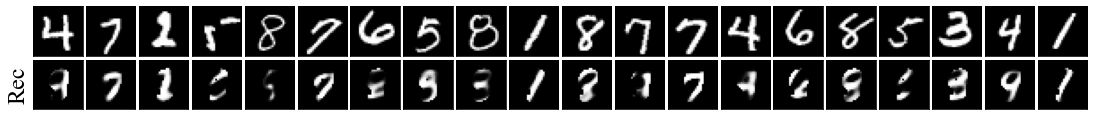

In [21]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

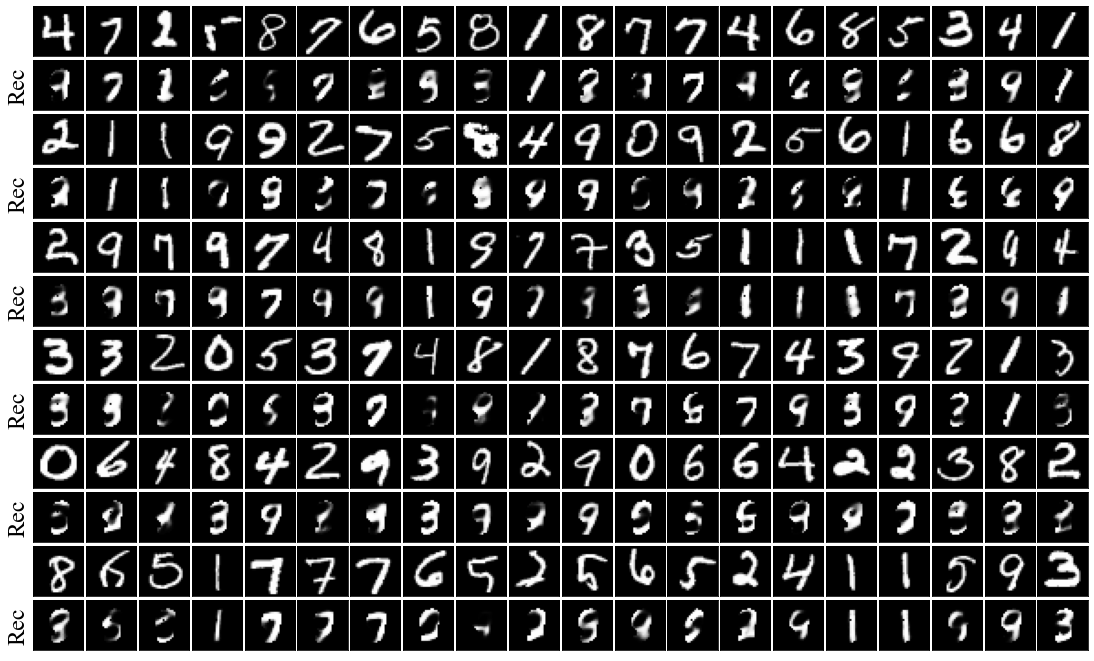

In [22]:
ncols = min(len(x_rec[0]), 20)
nrows = 2 * int(np.floor(len(x_rec[0]) / 20))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 1.5*nrows/2))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= nrows / 2 * 20:
        break
    for j, im in enumerate(aux):
        ax[j+i//20*2, i%20].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j+i//20*2, i%20].set_xticks([])
        ax[j+i//20*2, i%20].set_yticks([])
    ax[1+i//20*2, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRecExtra.pdf', dpi=300)

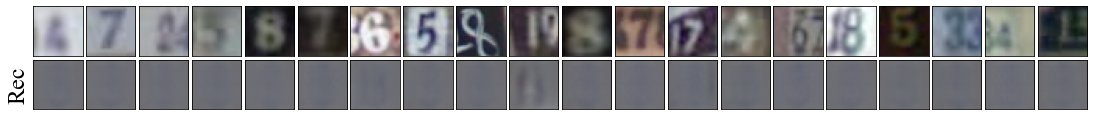

In [23]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'SVHNRec.pdf', dpi=300)

In [ ]:
ncols = min(len(x_rec[1]), 20)
nrows = 2 * int(np.floor(len(x_rec[1]) / 20))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 1.5*nrows/2))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= nrows / 2 * 20:
        break
    for j, im in enumerate(aux):
        ax[j+i//20*2, i%20].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[j+i//20*2, i%20].set_xticks([])
        ax[j+i//20*2, i%20].set_yticks([])
    ax[1+i//20*2, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'SVHNRecExtra.pdf', dpi=300)